# Get corrections at a corner reflector (CR) location using GridGeococoding

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../..")

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from matplotlib import pyplot as plt

import s1etad
from s1etad import Sentinel1Etad
from s1etad.geometry import GridGeocoding

## Searching bursts in which the CR is present

Load the S1-ETAD product.

In [2]:
filename = (
    "data/"
    "S1A_IW_ETA__AXDV_20230806T211729_20230806T211757_049760_05FBCB_9DD6.SAFE"
)

In [3]:
eta = Sentinel1Etad(filename)

The CR position has been chosen to be in the overlap region of different bursts and swaths.

In [4]:
from shapely.geometry import Point

lat0 = 32.968825  # 32°58'7.77"N
lon0 = 131.3652  # 131°21'54.72"E
h0 = 304.0

cr = Point(lon0, lat0)

Query for burst covering the CR.

In [5]:
selection = eta.query_burst(geometry=cr)
selection

,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
12,8,1,2,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW2,2023-08-06 21:17:35.659823903,2023-08-06 21:17:38.826979328
3,10,1,1,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW1,2023-08-06 21:17:37.478005721,2023-08-06 21:17:40.645161146
13,11,1,2,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW2,2023-08-06 21:17:38.416422143,2023-08-06 21:17:41.612903082


## Get corrections at CR location

Retrieve the first burst.

In [6]:
burst = next(eta.iter_bursts(selection))

Get the grid of geodetic coordinates.

In [7]:
lats, lons, heights = burst.get_lat_lon_height()

Get the range and azimuth time axes.

In [8]:
azimuth_time, range_time = burst.get_burst_grid()

Initialize the Grid Geocoding object.

**NOTE**: if one uses time axis then consistent time coordinates shall be provided in all back-geocoding requests.

In [9]:
ebg = GridGeocoding(lats, lons, heights, xaxis=range_time, yaxis=azimuth_time)

Now it is possible to perform the back-geocoding i.e. computation of RADAR coordinates (tau, t) starting form geodetic coordinates (lat, lon, h):

   (lat, lon, h) -> (tau, t) 

In [10]:
tau, t = ebg.backward_geocode(lat0, lon0, h0)
tau, t

(array([0.00031842]), array([9.42706234]))

Of course it is also possible to make the inverse conversion:

In [11]:
lat1, lon1, h1 = ebg.forward_geocode(tau, t)
print(f"Initial coordinates:      (lat0, lon0, h0) = ({lat0}, {lon0}, {h0})")
print(
    "Forward geocoding output: "
    f"(lat1, lon1, h1) = ({lat1.item()}, {lon1.item()}, {h1.item()})"
)

Initial coordinates:      (lat0, lon0, h0) = (32.968825, 131.3652, 304.0)
Forward geocoding output: (lat1, lon1, h1) = (32.96882500000001, 131.36520000000004, 331.88771594615156)


### Using image coordinates (lines, samples)

It is also possible to initialize the GridGeocoding without providing time axes information.

In this case the geocoder will work using image coordinates (lines and samples) instead of range/azimuth times.

In [12]:
ebg = GridGeocoding(lats, lons, heights)

It is possible to perform back-geocoding, i.e. (lat, lon, h) -> (sample, line):

In [13]:
sample, line = ebg.backward_geocode(lat0, lon0, h0)
sample, line

(array([10.58569122]), array([101.46282565]))

and also to perform the forward conversion: (sample, line) -> (lat, lon, h)

In [14]:
lat1, lon1, h1 = ebg.forward_geocode(sample, line)
print(f"Initial coordinates:      (lat0, lon0, h0) = ({lat0}, {lon0}, {h0})")
print(
    "Foeward geocoding output: "
    f"(lat1, lon1, h1) = ({lat1.item()}, {lon1.item()}, {h1.item()})"
)

Initial coordinates:      (lat0, lon0, h0) = (32.968825, 131.3652, 304.0)
Foeward geocoding output: (lat1, lon1, h1) = (32.968824999999995, 131.36519999999993, 331.88771594595636)


## Putting all together

xy   IW2 8 [10.58569122] [101.46282565] [32.968825] [131.3652] [331.88771595]
time IW2 8 [0.00031842] [9.42706234] [32.968825] [131.3652] [331.88771595]
Interpolation by array coordinate [3.1933344] or time [3.1933344] should be the same
The total correction at lat/lon (32.968825, 131.3652) is [3.1933344] m in range

xy   IW1 10 [391.58561982] [39.4628219] [32.968825] [131.3652] [331.8869369]
time IW1 10 [0.00031842] [9.42706223] [32.968825] [131.3652] [331.8869369]
Interpolation by array coordinate [3.69389987] or time [3.69389987] should be the same
The total correction at lat/lon (32.968825, 131.3652) is [3.69389987] m in range

xy   IW2 11 [10.58550757] [7.46282484] [32.968825] [131.3652] [331.88500572]
time IW2 11 [0.00031842] [9.42706231] [32.968825] [131.3652] [331.88500572]
Interpolation by array coordinate [3.98766172] or time [3.98766172] should be the same
The total correction at lat/lon (32.968825, 131.3652) is [3.98766172] m in range



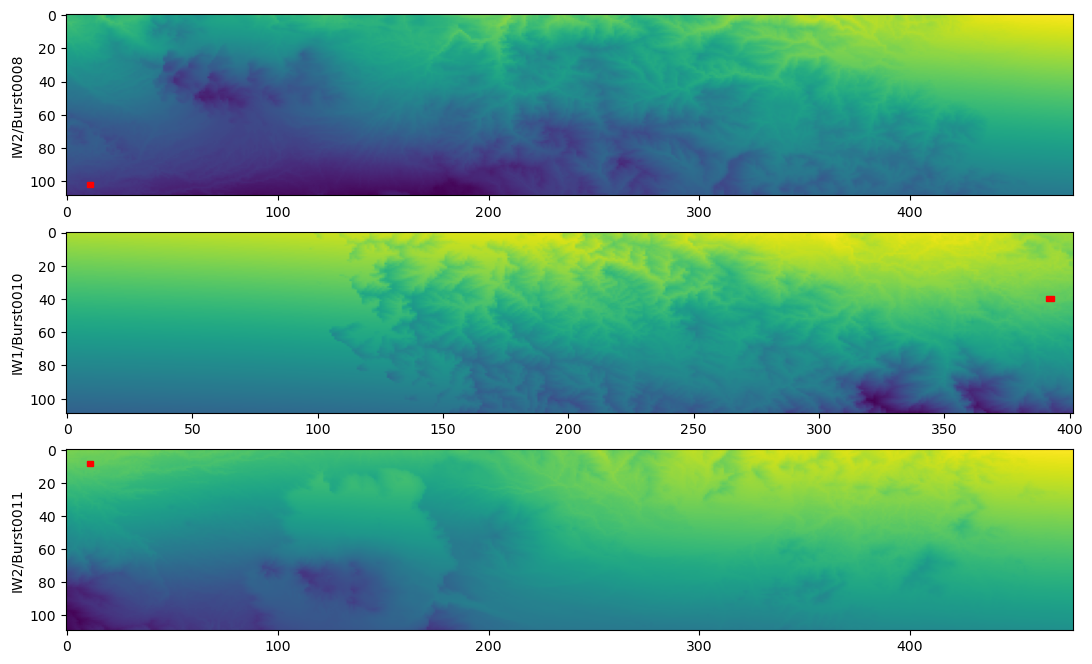

In [15]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(nrows=len(selection), ncols=1, figsize=[13, 8])

for loop, burst in enumerate(eta.iter_bursts(selection)):
    # coordinate grids
    lats, lons, heights = burst.get_lat_lon_height()

    # backward geocoding with image coordinates
    ebg = GridGeocoding(lats, lons, heights)
    x0, y0 = ebg.backward_geocode(lat0, lon0, h0)
    print(
        "xy  ",
        burst.swath_id,
        burst.burst_index,
        x0,
        y0,
        ebg.latitude(x0, y0),
        ebg.longitude(x0, y0),
        ebg.height(x0, y0),
    )

    # get the range and azimuth times
    azimuth_time, range_time = burst.get_burst_grid()

    # backward geocoding with time coordinates
    ebg = GridGeocoding(
        lats, lons, heights, xaxis=range_time, yaxis=azimuth_time
    )
    tau0, t0 = ebg.backward_geocode(lat0, lon0, h0)
    print(
        "time",
        burst.swath_id,
        burst.burst_index,
        tau0,
        t0,
        ebg.latitude(tau0, t0),
        ebg.longitude(tau0, t0),
        ebg.height(tau0, t0),
    )

    # correction
    cor = burst.get_correction(s1etad.ECorrectionType.SUM, meter="True")

    ax[loop].imshow(cor["x"], aspect="auto")
    ax[loop].set_ylabel(f"{burst.swath_id}/{burst.burst_id}")
    rec_half_size = 1
    p = Rectangle(
        (x0 - rec_half_size, y0 - rec_half_size),
        width=rec_half_size * 2 + 1,
        height=rec_half_size * 2 + 1,
        color="red",
        fill=True,
    )
    ax[loop].add_patch(p)

    # interpolate at the desired working (RADAR) coordinates
    f_t = RegularGridInterpolator((range_time, azimuth_time), cor["x"].T)

    # get the image (lines and samples) axes
    yaxis = np.arange(azimuth_time.size)
    xaxis = np.arange(range_time.size)

    # interpolate at the desired working (image) coordinates
    f_ij = RegularGridInterpolator((xaxis, yaxis), cor["x"].T)

    print(
        f"Interpolation by array coordinate {f_ij((x0, y0))} or "
        f"time {f_t((tau0, t0))} should be the same"
    )
    print(
        f"The total correction at lat/lon {lat0, lon0} is "
        f"{f_ij((x0, y0))} m in range"
    )
    print()

In [16]:
burst.radar_to_geodetic(tau0, t0)

(array([32.968825]), array([131.3652]), array([331.88500572]))

In [17]:
cor

{'x': array([[4.05822451, 4.0607732 , 4.05306037, ..., 4.39878131, 4.39897736,
         4.39914722],
        [4.0458467 , 4.05001574, 4.0482936 , ..., 4.3906227 , 4.39040733,
         4.39159507],
        [4.0477595 , 4.03773197, 4.03714374, ..., 4.38187025, 4.38249812,
         4.38309924],
        ...,
        [2.67421528, 2.68387344, 2.69863569, ..., 3.54058138, 3.5411553 ,
         3.54173328],
        [2.65510669, 2.67399737, 2.69620666, ..., 3.53260976, 3.53318217,
         3.53376219],
        [2.64196745, 2.65870343, 2.67874309, ..., 3.52462466, 3.52520104,
         3.52578767]], shape=(110, 478)),
 'y': array([[-1.37837932, -1.37512413, -1.39237992, ..., -2.14400831,
         -2.1436258 , -2.14326606],
        [-1.39020902, -1.38386951, -1.38911398, ..., -2.15940761,
         -2.15987731, -2.1576086 ],
        [-1.37411534, -1.39526828, -1.39826819, ..., -2.17580657,
         -2.17471202, -2.17364075],
        ...,
        [-0.35608611, -0.38188736, -0.41922822, ..., -3.074353